## TODO:

* load poses and point clouds
* get sensor beam angles
* modify get_rays() to use VLP-64 beam angles (not regularly spaced)
* get rays_o/d poses1
* verify frame alignment

In [1]:
import numpy as np
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
from scipy.spatial.transform import Rotation as R
import trimesh
from matplotlib import pyplot as p
import tensorflow as tf

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 10*1024 #22*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print("error")
    print(e)
#-----------------------------------------------------------------

from lidar_nerf_utils import *
import time
import cv2

%load_ext autoreload
%autoreload 2
%autosave 180

2024-09-30 12:43:02.142968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 12:43:02.245477: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 12:43:02.643167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2024-09-30 12:43:02.643255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7:

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-09-30 12:43:03.552810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 12:43:03.553841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-30 12:43:03.554111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-30 12:43:03.554306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

idx1 = 1
pcfn = "/media/derm/06EF-127D4/mai_city/txt/00/" +  f"{idx1:06}" #+ ".txt"
pc1 = np.loadtxt(pcfn)
disp.append(Points(pc1, r = 3, c = 'red', alpha = 0.2))

idx2 = 15
pcfn = "/media/derm/06EF-127D4/mai_city/txt/00/" +  f"{idx2:06}" #+ ".txt"
pc2 = np.loadtxt(pcfn)
pc2 += np.array([idx2-idx1,0,0])
disp.append(Points(pc2, r = 3, c = 'blue', alpha = 0.2))

plt.show(disp, "using data from rosbag not ply files")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

[1. 0. 0. 5. 0. 1. 0. 0. 0. 0. 1. 0.]


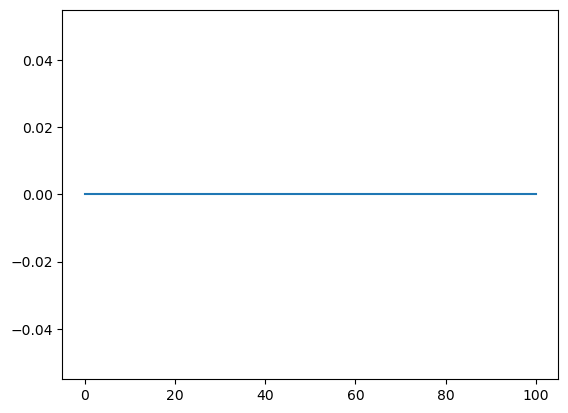

In [3]:
poses = np.loadtxt("/media/derm/06EF-127D4/mai_city/bin/poses/01.txt")
print(poses[5])
trans = np.array([poses[:,3], poses[:,7], poses[:,11]])

fig, ax = p.subplots()
ax.plot(trans[0,:], trans[1,:])

# Issue-- can't use simple look directions on PC as provided

### TODO
* re-distort (can't just align and train right away though!)
* split each scan into 128 horizontal slices
* get pose, rays_o, rays_d for each slice
* get training "images" from each slice
* train rest of the way as normal

In [4]:
n_rots = 512 #128 #number of horizontal subdivisions in sweep 
n_frames = 50 #5 #20 
use_every = 2 #5 #1
scale_factor = 1/200
# scale_factor = 1/600
H = 64
W = 2048//n_rots
# sequence = "00"
sequence = "01"

images = np.ones([n_frames*n_rots, 64, 2048//n_rots, 2]) #depth and raydrop channels (default all raydrop to 1)
rays_o_all = np.zeros([n_frames*n_rots, 64, 2048//n_rots, 3]) 
rays_d_all = np.zeros([n_frames*n_rots, 64, 2048//n_rots, 3]) 
count = 0

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#go through frames in training data
# for idx in range(0,use_every*n_frames,use_every): #train set
for idx in range(1,use_every*n_frames,use_every): #test set
    print(idx)
    pcfn = "/media/derm/06EF-127D4/mai_city/txt/" + sequence + "/" +  f"{idx:06}" #+ ".txt"
    pc1 = np.loadtxt(pcfn)
        
    m_hat = np.array([0.,0.,0.,0.,0.,0.])
#     m_hat = np.array([-1.,0.,0.,0.,0.,0.])
    pc1_distorted = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     pc1_distorted += np.array([1,0,0]) #nope
    pc1_distorted = pc1_distorted[:131_072,:] #crop down to 2048 "pixels" in sweep
    pc1 = pc1[:131_072,:] #test

    #TEST-- reorganaize pc1 and pc1_distorted by azimuth angle
#     sort_idx = np.argsort((cartesian_to_spherical(pc1)[:,1] + 2*np.pi)%(2*np.pi))
    sort_idx = np.argsort((cartesian_to_spherical(pc1_distorted)[:,1] + 2*np.pi)%(2*np.pi)) #TEST
    pc1 = pc1[sort_idx]
    pc1_distorted = pc1_distorted[sort_idx]
        
    #break scan into n_rots azimuthal patches (use this for batching)
    for r in range(n_rots):
        pc1_patch = pc1_distorted[r*W*H:(r+1)*W*H,:] #had this (good fill but distorted alignment)
#         pc1_patch = pc1[r*W*H:(r+1)*W*H,:] #good fill of red scans but distorted depth values? 
        #get rays_d directly
        norm = np.sqrt(np.sum(pc1_patch**2, axis = 1))
        rays_d_patch = pc1_patch/norm[:,None]
        rays_d_all[count] = np.reshape(rays_d_patch, [64, -1, 3]) #was this
#         rays_d_all[count] = np.transpose(np.reshape(rays_d_patch, [-1, 64, 3]), [1,0,2]) #test
        
        #hold on to depth image
        pc1_spherical = cartesian_to_spherical(pc1_patch) #old (use distorted image)
#         pc1_spherical = cartesian_to_spherical(pc1_distorted[r*W*H:(r+1)*W*H,:])        #test
#         pc1_spherical = cartesian_to_spherical(pc1[r*W*H:(r+1)*W*H,:])        #test
        #had this -- was messing with order of points in rays_d??
#         pc1_depth_image = np.reshape(pc1_spherical[:,0], [-1,64]).T 
        pc1_depth_image = np.reshape(pc1_spherical[:,0], [64,-1])  #TEST
        images[count,:,:,0] = pc1_depth_image*scale_factor
        #TEST-- add nose to depth images to prevent network from overfitting(?)
#         images[count,:,:,0] += np.random.rand(H,W)*(scale_factor/100)
        
        #get rays_o
        rays_o = np.array([idx, 0., 0.])*scale_factor
#         rays_o += np.array([0.3,0.5,0.]) #bring back to [0,1] -- not needed(?)
        rays_o = np.tile(rays_o, [1,64, 2048//n_rots,1])
        rays_o_all[count] = rays_o

#         rays_d_all[count] += np.array([(r/n_rots), 0., 0.])*scale_factor #TEST

        count += 1
        
#         #add back in distortion correction for visualization 
# #         pc1_patch = pc1_patch + np.array([idx + r/n_rots,0,0])       
#         pc1_patch = pc1_patch + np.array([idx,0,0])        
#         disp.append(Points(pc1_patch, r = 3, c = np.random.rand(3), alpha = 0.2))
# #         disp.append(Points(pc1_patch, r = 3, c = 'k', alpha = 0.2))

images = images.astype(np.float32)
poses = poses.astype(np.float32)
rays_d_all = rays_d_all.astype(np.float32)
rays_o_all = rays_o_all.astype(np.float32)

plt.show(disp, "using data from rosbag not ply files")
ViewInteractiveWidget(plt.window)

1


/home/derm/ASAR/v3/nerf/lidar_nerf_utils.py:800: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]
2024-09-30 12:43:20.837400: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-09-30 12:43:20.837420: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-09-30 12:43:20.837439: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older

3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [ ]:
# #TEST-- reorganaize pc1 and pc1_distorted by azimuth angle
# # sort_idx = np.argsort((cartesian_to_spherical(pc1)[:,1] + 2*np.pi)%(2*np.pi))
# # pc1 = pc1[sort_idx]
# # pc1_distorted = pc1_distorted[sort_idx]

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
# disp=[]  

# pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{idx:06}" #+ ".txt"
# pc1 = np.loadtxt(pcfn)
# # m_hat = np.array([0.,0.,0.,0.,0.,0.])
# m_hat = np.array([-1.,0.,0.,0.,0.,0.])
# pc1_distorted = apply_motion_profile(pc1, m_hat, period_lidar=1.)
# # pc1_distorted = pc1_distorted[:131_072,:] #crop down to 2048 "pixels" in sweep
# # pc1 = pc1[:131_072,:] 
# pc1 = pc1[50_000:52_000,:] 
# pc1_distorted = pc1_distorted[50_000:52_000,:] 

# #TEST-- reorganaize pc1 and pc1_distorted by azimuth angle
# sort_idx = np.argsort((cartesian_to_spherical(pc1)[:,1] + 2*np.pi)%(2*np.pi))
# pc1 = pc1[sort_idx]
# pc1_distorted = pc1_distorted[sort_idx]

# color = np.linspace(0,1,len(pc1_distorted)) 
# cname = np.array([1-color, color, 1-color]).T.tolist()    
# disp.append(Points(pc1_distorted, c = cname))

# plt.show(disp, "Drawing training data from depth images, rays_o, and rays_d")
# ViewInteractiveWidget(plt.window)  


In [ ]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
# disp=[]  

# for idx in range(16):
#     tp = np.reshape(rays_o_all[idx], [-1,3]) + np.reshape(rays_d_all[idx], [-1,3])
#     color = np.linspace(0,1,len(tp)) 
# #     print(color)
#     cname = np.array([1-color, color, 1-color]).T.tolist()    
#     disp.append(Points(tp, c = cname))

# plt.show(disp, "Drawing training data from depth images, rays_o, and rays_d")
# ViewInteractiveWidget(plt.window)  

# Visualize training data from rays_o, rays_d, and images

In [ ]:
def draw_rays_from_img(disp, rays_o, rays_d, img, c = 'red'):
    ''' visualize rays extending forom sensor location provided by rays_o, rays_d, and depth img '''

    line = []
    rof = np.reshape(rays_o, [-1,3])
    rdf = np.reshape(rays_d, [-1,3])
    imf = img.flatten()
    for i in range(len(rof)):
        line.append(Line(rof[i], rof[i] + rdf[i]*imf[i], alpha = 0.3, c = 'purple')) #was this before embeddings rays_o in rays_d
#         line.append(Line(rof[i], rdf[i]*imf[i], alpha = 0.3, c = 'purple'))
    # Merge lines only if there are any
    if line:
        merged_lines = merge(line)  # Merge the lines
        if merged_lines:  # Check if merge was successful
            merged_lines.color(c)  # Set color after merging
            disp.append(merged_lines)  # Add the merged lines to display
    
def draw_frame_from_rays(disp, n_rots=128, n_vert_patches=1, frameIdx=0, color = 'red'):
    '''given rays_o and rays_d, recreate point cloud'''
    
    H = 64 // n_vert_patches
    W = 2048 // n_rots    
    
    pts1 = np.zeros([1,3])
    for p in range(frameIdx*(n_rots), (frameIdx + 1 )*(n_rots)):
#     for p in range(frameIdx*(n_rots), (frameIdx*n_rots) + n_rots//3):
        rays_o = rays_o_all[p]
        rays_d = rays_d_all[p]
        img = images[p, :, :, 0]
        
        inMap1 = add_patch(rays_o, rays_d, images[p,:,:,0])

        pts1 = np.append(pts1, inMap1, axis = 0)
        disp.append(Points(rays_o[frameIdx,:1,:], r = 15, c = 'purple', alpha = p/n_rots)) #DEBUG  

        #FOR DEBUG-- draw swaths from each scan looking at mailbox
        if p == 14*8 + 2:
            draw_rays_from_img(disp, rays_o, rays_d, img, c = 'red')
        if p == 14*8 + 3: #15
            draw_rays_from_img(disp, rays_o, rays_d, img, c = 'green')
        if p == 14*8 + 4: #41
            draw_rays_from_img(disp, rays_o, rays_d, img, c = 'blue')
            
#     color = 'red'#for debug
    vizPts1 = Points(pts1, c = color, r = 3., alpha = 0.125)
    disp.append(vizPts1)  

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]          

# colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'red']
colors = np.linspace(0.1,0.3,n_frames)[:,None] * np.array([[1,1,1]])
for i in range(len(colors)):
# for i in range(1): 
    draw_frame_from_rays(disp, n_rots = 16, n_vert_patches=1, frameIdx = i, color=colors[i])

# disp = merge(disp)
    
plt.show(disp, "Drawing training data from depth images, rays_o, and rays_d")
ViewInteractiveWidget(plt.window)  

In [ ]:
#make sure rays_o/d are corresponding to correct pixels
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

i = 14*8 + 3

rays_o = rays_o_all[14*8 + 2]
rays_d = rays_d_all[14*8 + 2]
rd = tf.reshape(rays_d, [-1,3])
# print(np.shape(rays_d))
im = images[14*8 + 2,:,:,0]
test = tf.reshape(rays_d * images[14*8 + 2,:,:,:1], [-1,3]) + tf.reshape(rays_o, [-1,3])
order = np.linspace(0.,1., len(test))
cname = np.array([1-order, order, order]).T.tolist()
disp.append(Points(test, c = cname))

rays_o = rays_o_all[14*8 + 3]
rays_d = rays_d_all[14*8 + 3]
rd = tf.reshape(rays_d, [-1,3])
im = images[14*8 + 3,:,:,0]
print(np.shape(rays_o), np.shape(test))
test = tf.reshape(rays_d * images[14*8 + 3,:,:,:1], [-1,3]) + tf.reshape(rays_o, [-1,3])

order = np.linspace(0.,1., len(test))
cname = np.array([1-order, order, order]).T.tolist()
disp.append(Points(test, c = cname))


plt.show(disp, "Drawing training data from depth images, rays_o, and rays_d")

ViewInteractiveWidget(plt.window)  

## Sort image patches along both axis

In [ ]:
print(np.shape(rays_d_all[i]))

i = 14*8 + 2

#get rays_d for problem image
rdt = np.reshape(rays_d_all[i], [-1,3])
#convtert to spherical but keep in same image-like format
rdts = cartesian_to_spherical(rdt) #[r, theta, phi ]
rdts = np.reshape(rdts, [64,16,3])[:,:,2]
#within each row, sort by elevation angle
print(np.shape(rdts))
better_idx = np.argsort(rdts, axis = 1)
print("better_idx", np.shape(better_idx), "\n", better_idx)

# test = np.take_along_axis(rdts, better_idx, axis = 0)
sorted_rays_d = np.take_along_axis(rays_d_all[i], better_idx[:,:,None], axis = 1)
# print(np.shape(np.reshape(rays_d_all[i], [-1,3])))
# test = np.reshape(rays_d_all[i], [-1,3])[better_idx]
print("sorted_rays_d", np.shape(sorted_rays_d) )#, sorted_rays_d)
# sorted_rays_d = np.reshape(sorted_rays_d, [-1, 3])

im = images[i,:,:,:1]
sorted_im = np.take_along_axis(im, better_idx[:,:,None], axis = 1)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
print("sorted_im", np.shape(sorted_im))
test = tf.reshape(sorted_rays_d*sorted_im, [-1,3]) + tf.reshape(rays_o, [-1,3])
order = np.linspace(0.,1., len(test))
cname = np.array([1-order, order, order]).T.tolist()
disp.append(Points(test, c = cname))
# disp.append(Points(np.reshape(sorted_rays_d, [-1,3]), r = 5, alpha = 0.1))
plt.show(disp, "Drawing training data from depth images, rays_o, and rays_d")

ViewInteractiveWidget(plt.window)  

In [ ]:
fig, ax = p.subplots()
ax.imshow(sorted_im)

In [ ]:
idx = 10
pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{idx:06}" #+ ".txt"
pc1 = np.loadtxt(pcfn)

m_hat = np.array([-1.,0.,0.,0.,0.,0.])
pc1_distorted = apply_motion_profile(pc1, m_hat, period_lidar=1.)

r = 14
pc1_spherical = cartesian_to_spherical(pc1_distorted[r*W*H:(r+1)*W*H,:])
# pc1_depth_image = np.reshape(pc1_spherical[:,0], [64,-1])
pc1_depth_image = np.reshape(pc1_spherical[:,0], [-1,64]).T #test

fig, ax = p.subplots()
# ax.imshow(images[-2,:,:,0])
ax.imshow(pc1_depth_image)

# Try training network

In [ ]:
z_vals = tf.linspace(0., 1., 128)
rays_o = rays_o_all[0].copy()
# z_vals += tf.random.uniform([128]) * (1.-0.)/32 #bad
z_vals += 0.01*tf.random.uniform([128]) * (1.-0.)/32 #better
print(z_vals)

fig, ax = p.subplots()
# ax.scatter(z_vals, np.zeros(len(z_vals)), alpha = 0.2)
ax.plot(np.diff(z_vals))

#bias sampling closer to origin
# z_vals = 2/(2-z_vals) - 1
z_vals = 1.125/(1.125-z_vals) - 1
z_vals /= z_vals[-1]

print(z_vals)
# ax.scatter(z_vals, np.zeros(len(z_vals)), alpha = 0.2)
ax.plot(np.diff(z_vals))
ax.set_ylabel("distance betwen subsequent z samples")
ax.set_xlabel("sample idx")
# ax.set_xlim([0,10])

2024-09-30 12:44:58.999785: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-30 12:44:59.084349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


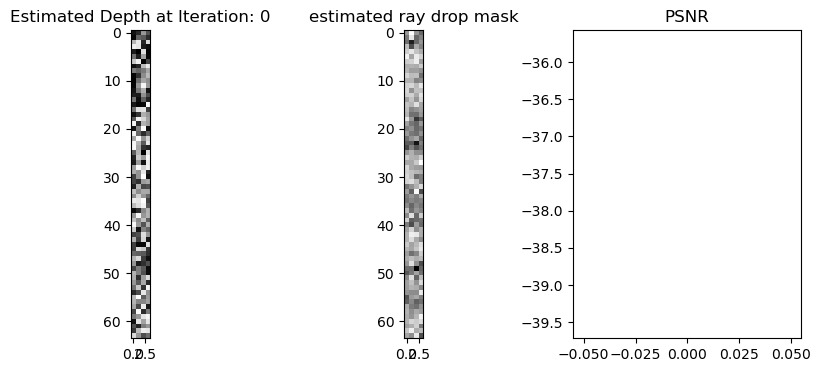


KeyboardInterrupt



In [5]:
from lidar_nerf_utils import *
from numpy.lib.stride_tricks import sliding_window_view

model = init_model()
# # ## model = model_fine # DEBUG - use from coarse to fine 
optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
# optimizer = tf.keras.optimizers.Adam(1e-4)
# optimizer = tf.keras.optimizers.Adam(5e-5) #anneal to this (LiDAR NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-5)
# optimizer = tf.keras.optimizers.Adam(5e-6) #anneal to this (Mip-NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-6) #TEST

N_samples = 128 #128 #256
near=0.
far= 1.
N_iters = 5_000_000
psnrs = []
iternums = []
i_plot = 128
accumulate_gradients_steps = 1 #32
# run_twice = True
run_twice = False

#IMPORTANT-- this needs to match values used when setting up training data 
n_rots = 512 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #1 #number of vertical patches between phimin and phimax (at time of data generation)
H = 64 // n_vert_patches
W = 2048 // n_rots
testimg = images[12]

gradients = [tf.zeros_like(var) for var in model.trainable_variables]
accumulated_loss = 0.0

for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])

    #use full verical patch
    target = images[img_i,:,:,:1].copy()
    target_drop_mask = images[img_i,:,:,1:].copy()
    rays_d = rays_d_all[img_i].copy()
    rays_o = rays_o_all[img_i].copy()
    
#     #break up scans vertically at train time
#     # this works but make sure to drop the LR proportionally!
#     patch_height = 16
#     vert_crop_start = np.random.randint(0,H - patch_height - 1)
#     vert_crop_end = vert_crop_start + patch_height
#     target = images[img_i,vert_crop_start:vert_crop_end,:,:1]
#     target_drop_mask = images[img_i,vert_crop_start:vert_crop_end,:,1:]
#     pose = poses[img_i]
#     rays_d = rays_d_all[img_i, vert_crop_start:vert_crop_end]
#     rays_o = rays_o_all[img_i, vert_crop_start:vert_crop_end]
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #IMPORTANT NOTE: z_vals must be in ascending order 
        
#         #bias sampling closer to origin
#         # z_vals = 2/(2-z_vals) - 1
#         z_vals = 1.125/(1.125-z_vals) - 1
#         z_vals /= z_vals[-1]

        
#         z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        loss_coarse = calculate_loss_Mai_City(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF) 
        #DEBUG-- use raw depth loss (rather than training off CDF)
#         loss_coarse = calculate_loss(depth, ray_drop, target, target_drop_mask)
        loss = loss_coarse

        #not technically correct but helps a to give a warm start
        if run_twice:
            # run through a 2nd time network ~~~~~~~~~~~~~~~~~~
            #pad weights with zeros
#             fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#             rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#             #use additional axis to calculate all at once
#             fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#             rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
            #TEST-- slightly wider blur-pool
            fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
            rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
            fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
            rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)

    
            #blur-pool as vectorized operation
            test2 = (fwd_test + rev_test) /2 #blur
    #         test2 += 1/N_samples #shift up slightly
            test2 += 1/(3*N_samples) #shift up slightly
            test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
            
            cum_hist_vals = np.cumsum(test2, axis = -1)
            cum_hist_vals_flat = cum_hist_vals.flatten()
    
            #modify cum_hist_vals so it is monotonically increasing (needed for interp func to work)
            step_corr = np.linspace(0,W*H-1,W*H)
            step_corr = np.tile(step_corr,(N_samples,1)).T
            step_corr = np.reshape(step_corr, [1,-1])[0,:]
            cum_hist_vals_flat+= step_corr
    
            linear_spaced = np.linspace(near, H*W, N_samples*H*W)
#             #fix spacing-- go all the way through [min, max] on every channel???
#             linear_spaced = np.linspace(near, far, N_samples)
#             linear_spaced = np.tile(linear_spaced, (H*W))
#             linear_spaced += step_corr

            ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
            ans -= step_corr
            ans *= far #scale back to max value
#             ans = np.abs(ans) #old-- was shifted to the left
            ans = np.abs(ans) + 1/N_samples #took forever to figure this one out...
            z_vals = np.reshape(ans, [H,W,N_samples,1])
            
            gtCDF = z_vals[:,:,:,0] > target[:,:,:]
            gtCDF = tf.cast(gtCDF, tf.float32)
            
#             print(rays_o[0,0,:])
#             print(rays_d[0,0,:])
#             print(z_vals[0,0,:,0])
            rays_o  = tf.cast(rays_o, tf.float32)
            rays_d  = tf.cast(rays_d, tf.float32)
            z_vals  = tf.cast(z_vals, tf.float32)
    
            #run actual 2nd pass through same network
            depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
            depth = depth[:,:,None]
            depth = tf.cast(depth, tf.float32) #why do I have to cast this here???
            ray_drop = ray_drop[:,:,None]
            
            # loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask)
            loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
            loss = 0.1*loss_coarse + 0.9*loss_fine 
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
        
        #NEW--prevent NaN gradients from crashing training routine(?) -- needed for monotonically increasing outputs?
        current_gradients = tape.gradient(loss, model.trainable_variables)
        current_gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(current_gradients, model.trainable_variables)]
        gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]        

#         #OLD-- not working with CDF stuff
#         current_gradients = tape.gradient(loss, model.trainable_variables)
#         gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]    
        
        accumulated_loss += loss
    
    if i%accumulate_gradients_steps==0:    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accumulated_loss = 0.0
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]
        accumulated_loss = 0
    
    if i%i_plot==0:
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

# generate scan from single network

In [ ]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

look_at_scan = 4
N_samples = 512
# run_twice = True
run_twice = False

for j in range(look_at_scan*n_rots, (look_at_scan+1)*n_rots):
    idx = j    
    rays_d = rays_d_all[idx].copy()
    rays_o = rays_o_all[j].copy() #use moving base of platfrom (like in training data)
    ##---> TODO-- why does this still look distorted!?!
#     rays_o = rays_o_all[look_at_scan*n_rots].copy() #simulate static base 

    
    z_vals = tf.linspace(near, far, N_samples) 
    
#     #bias sampling closer to origin
#     # z_vals = 2/(2-z_vals) - 1
#     z_vals = 1.125/(1.125-z_vals) - 1
#     z_vals /= z_vals[-1]
    
#     z_vals += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals = z_vals[:,:,:,None]
    
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
#     depth = tf.transpose(depth).numpy() #need this
#     depth = np.flip(depth, axis = 0) #needed

    #not technically correct but helps a to give a warm start
    if run_twice:
        # run through a 2nd time network ~~~~~~~~~~~~~~~~~~
        #pad weights with zeros
#             fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#             rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#             #use additional axis to calculate all at once
#             fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#             rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
        #TEST-- slightly wider blur-pool
        fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
        rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
        fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
        rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)


        #blur-pool as vectorized operation
        test2 = (fwd_test + rev_test) /2 #blur
        test2 += 1/(3*N_samples) #shift up slightly
        test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize

        cum_hist_vals = np.cumsum(test2, axis = -1)
        cum_hist_vals_flat = cum_hist_vals.flatten()

        #modify cum_hist_vals so it is monotonically increasing (needed for interp func to work)
        step_corr = np.linspace(0,W*H-1,W*H)
        step_corr = np.tile(step_corr,(N_samples,1)).T
        step_corr = np.reshape(step_corr, [1,-1])[0,:]
        cum_hist_vals_flat+= step_corr

        linear_spaced = np.linspace(near, H*W, N_samples*H*W)

        ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
        ans -= step_corr
        ans *= far #scale back to max value
#             ans = np.abs(ans) #old-- was shifted to the left
        ans = np.abs(ans) + 1/N_samples #took forever to figure this one out...
        z_vals = np.reshape(ans, [H,W,N_samples,1])

        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        rays_o  = tf.cast(rays_o, tf.float32)
        rays_d  = tf.cast(rays_d, tf.float32)
        z_vals  = tf.cast(z_vals, tf.float32)

        #run actual 2nd pass through same network
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
#         depth = tf.transpose(depth).numpy() #need this
#         depth = np.flip(depth, axis = 0) #needed
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   

    
    #scale back up to normal size
#     depth *= scale_factor
    ray_drop = tf.transpose(ray_drop).numpy()
    ray_drop = np.flip(ray_drop, axis = 0)
    #just use rays_d to get point directions! 
    new_point_cloud_cart = depth[:,:,None]*rays_d + rays_o
    new_point_cloud_cart = np.reshape(new_point_cloud_cart, [-1,3])
    
    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
#     disp.append(Points(rays_d[:10,0,:], c = 'blue', r = 10))
#     disp.append(Points(np.random.randn(10,3), c = 'red', r = 3))
    
plt.show(disp, "reproducing first training scan using network")
ViewInteractiveWidget(plt.window)   

# Train using coarse-to-fine approach


 iteration: 0


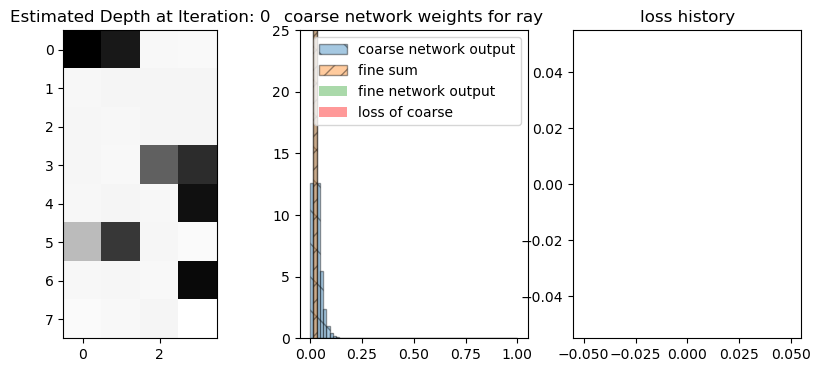

KeyboardInterrupt: 

In [8]:
from lidar_nerf_utils import *
from coarse_network_utils import*

# model_coarse = init_model_proposal()
# model_fine = init_model()
# model_fine = model #warm start from previous training loop
# loss_hist = np.zeros([0])

# optimizer_coarse = tf.keras.optimizers.Adam(1e-3)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-4)
# optimizer_coarse = tf.keras.optimizers.Adam(5e-5)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-5)
# optimizer_coarse = tf.keras.optimizers.Adam(5e-6)
optimizer_coarse = tf.keras.optimizers.Adam(1e-6)
# optimizer_coarse = tf.keras.optimizers.Adam(5e-7)

# optimizer_fine = tf.keras.optimizers.Adam(5e-4)
# optimizer_fine = tf.keras.optimizers.Adam(1e-4)
# optimizer_fine = tf.keras.optimizers.Adam(5e-5)
# optimizer_fine = tf.keras.optimizers.Adam(2.5e-5)
# optimizer_fine = tf.keras.optimizers.Adam(1e-5)
# optimizer_fine = tf.keras.optimizers.Adam(5e-6)
# optimizer_fine = tf.keras.optimizers.Adam(1e-6)
optimizer_fine = tf.keras.optimizers.Adam(5e-7)

n_bins_fine = 512 #512 #128
n_bins_coarse = 64 #64 #32
near=0.
far=1.
N_iters = 1_000_000 #5_000
psnrs = []
iternums = []
i_plot = 2048 #256

n_rots = 512 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

loss_since_last_plot = np.zeros([0])
for i in range(N_iters):
    img_i = np.random.randint(images.shape[0])

#     #use full vertical span of patch 
#     target = images[img_i,:,:,:1]
#     target_drop_mask = images[img_i,:,:,1:]
#     rays_d = rays_d_all[img_i]
#     rays_o = rays_o_all[img_i]
        
    #break up scans vertically at train time
    # this works but make sure to drop the LR proportionally!
    patch_height = 8 #16
    vert_crop_start = np.random.randint(0,H - patch_height - 1)
    vert_crop_end = vert_crop_start + patch_height
    target = images[img_i,vert_crop_start:vert_crop_end,:,:1]
    target_drop_mask = images[img_i,vert_crop_start:vert_crop_end,:,1:]
    rays_d = rays_d_all[img_i, vert_crop_start:vert_crop_end]
    rays_o = rays_o_all[img_i, vert_crop_start:vert_crop_end]

    with tf.GradientTape() as tape_coarse, tf.GradientTape() as tape_fine:
#     with tf.GradientTape() as tape_coarse:
        #run coarse network first to get locations to evaluate fine model at ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        #DEBUG:
#         z_vals_coarse += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2
#         print("z_vals_coarse", z_vals_coarse[0,0,:,0] - width_coarse[0,0,:,0]/2)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                     #repeat_coarse = False)    
        
        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]
                
        # run fine network to get actual scene density ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals_fine[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        
        #weights of zero will produce zero area, leading to NaN loss
#         area_fine = tf.reduce_sum(weights_fine * width_fine, axis=2, keepdims=True)
#         print("weights fine before fix: \n", (weights_fine/area_fine)[0,0,:].numpy())             
        epsilon = 1e-6
#         padded_area_by_bin = weights_fine * width_fine + epsilon*tf.ones_like(width_fine) #was this
        padded_area_by_bin = (weights_fine + epsilon*tf.ones_like(width_fine)) * width_fine #slightly closer?
        area_fine = tf.reduce_sum(padded_area_by_bin, axis=2, keepdims=True)       
        weights_fine /= area_fine
#         print("weights fine after fix: \n", weights_fine[0,0,:].numpy())
#         print("min(area_fine)", tf.math.reduce_min(area_fine))

        #per mip-nerf 360, calculate fine losss first
        loss_fine = calculate_loss_Mai_City(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
        ##DEBUG-- run traditional "direct depth" loss
        #loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask)

        weights_fine_stopped = tf.stop_gradient(weights_fine)
        loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                                z_vals_fine[:,:,:,0], 
                                                                weights_coarse[:,:,:,0], 
                                                                weights_fine_stopped, 
                                                                width_coarse[:,:,:,0],
                                                                width_fine[:,:,:],
                                                                debug = True)

        #TODO-- see if training works better without 
#         loss_coarse = loss_coarse * target_drop_mask[:,:,0] #suppress pixels with ray drop
        loss_coarse = tf.math.reduce_sum(loss_coarse)
        
        # Compute gradients and apply them
        gradients_fine = tape_fine.gradient(loss_fine, model_fine.trainable_variables)
        optimizer_fine.apply_gradients(zip(gradients_fine, model_fine.trainable_variables))        
        
        gradients_coarse = tape_coarse.gradient(loss_coarse, model_coarse.trainable_variables)
        optimizer_coarse.apply_gradients(zip(gradients_coarse, model_coarse.trainable_variables))
        
        #temp
#         loss_hist = np.append(loss_hist, loss_fine)
#         print(loss_hist)


    if i % i_plot == 0:
        
        loss_hist = np.append(loss_hist, np.mean(loss_since_last_plot))
        loss_since_last_plot = np.zeros([0])
        
        #rescale weights_coarse before plotting ~~~~~~~~
        eps = 1e-3 #1e-3
        weights_coarse = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse = weights_coarse/ tf.math.reduce_sum(width_coarse*weights_coarse, axis = 2)[:,:,None]
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        print("\n iteration:", i)            
        mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
        L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]

        look_at = 0
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(132)
        p.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'coarse network output', hatch = '\\', edgecolor = 'black')

        p.bar(z_vals_coarse[look_at,0,:,0], fine_sum[look_at,0,:], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'fine sum', hatch = '//', edgecolor = 'black')

        p.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width=width_fine[look_at,0,:],
             alpha = 0.4, label= 'fine network output')
        p.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at,0,:]/width_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
              bottom = weights_coarse[look_at,0,:,0], alpha = 0.4, color = 'red', 
              label= 'loss of coarse')    
        p.ylim([0,25])
        p.title('coarse network weights for ray')
        p.legend(loc="best")
        
        p.subplot(133)
        p.title("loss history")
        p.plot(loss_hist)
        p.show()
    else:
        loss_since_last_plot = np.append(loss_since_last_plot, loss_fine)

In [ ]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig, ax = p.subplots()

good = np.invert(np.isnan(loss_hist))
smoothed = moving_average(loss_hist[good][:])
ax.plot(smoothed)
# ax.plot(loss_hist[300:])
print(len(loss_hist))

#dropped LR from 2.5e-5 to 5e-6 @ 2k

# Render from Coarse-to-Fine

In [9]:
num_view = 512 #128 #number of rotational patches to draw
n_bins_coarse = 64 #64 #32
n_bins_fine = 512 #2048 #512 #256

look_at_scan  = 15 #6 #look at this scan

near=0.
far= 1.
n_rots = 512 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save point cloud to external file

very_beginning = time.time()

for j in range(look_at_scan*n_rots, look_at_scan*n_rots + num_view):

    #use |training poses and view directions
    rays_d = rays_d_all[j] #get view directions
    rays_o = rays_o_all[j] #use moving base of platfrom (like in training data)
#     rays_o = rays_o_all[look_at_scan*n_rots] #simulate static base

#     #use Ouster OS1-64 sensor model to specify new points and view directions
#     # phimin = np.deg2rad(-15.593) #actual OS1
#     # phimax = np.deg2rad(17.743)
#     phimin = np.deg2rad(0) #debug
#     phimax = np.deg2rad(25)
#     rotm = np.eye(4)
#     rotm[0,-1] = 12.25/200 #translate forward
#     rotm[1,-1] += 3/200 #move down side street
# #     rotm[2,-1] += 1/200 #raise sensor
#     #rotate sensor about its vertical axis
#     rotm[:3,:3] = rotm[:3,:3] @ R.from_euler('xyz', [0,0,2*np.pi*j/n_rots]).as_matrix()
#     rotm = tf.cast(rotm, tf.float32)
#     rays_o, rays_d = get_rays(H, W, rotm, phimin, phimax)

    z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
    z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
    z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
    #move z vals coarse to center of histogram bins ~~~~~~~~~~~
    width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
    width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
    z_vals_coarse = z_vals_coarse + width_coarse/2
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
    z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                 rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                 #repeat_coarse=False)    
    eps = 1e-3 #1e-3
    weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
    weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]
    
    z_vals_fine = z_vals_fine[:, :, :, None]
    weights_coarse = weights_coarse[:, :, :, None]
        
    #RUN FINE NETWORK
    depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)    
    
    #scale back up to normal size
#     depth *= scale_factor
    ray_drop = tf.transpose(ray_drop).numpy()
    ray_drop = np.flip(ray_drop, axis = 0)
    #just use rays_d to get point directions! 
    new_point_cloud_cart = depth[:,:,None]*rays_d + rays_o
    new_point_cloud_cart = np.reshape(new_point_cloud_cart, [-1,3])
    
    savepc = np.append(savepc, new_point_cloud_cart, axis = 0)
    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))

plt.show(disp, "MIP-NeRF 360 Coarse to Fine Approach")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# draw synthetic PC on top of actual scan

In [12]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{(2*look_at_scan + 1):06}" #+ ".txt"
# pcfn = "/media/derm/06EF-127D4/mai_city/txt/00/" +  f"{look_at_scan:06}" #+ ".txt"
pc1 = np.loadtxt(pcfn)
pc1 = pc1[:131_072,:]
disp.append(Points(pc1, c = 'gray', r = 3, alpha = 0.2))

# reconstructed_pc = ((savepc-np.array([0.3,0.5,0.])) / scale_factor) - np.array([look_at_scan, 0, 0])
reconstructed_pc = ((savepc) / scale_factor) - np.array([2*look_at_scan + 1, 0, 0])
disp.append(Points(reconstructed_pc, c = 'r', r = 3, alpha = 0.2))

plt.show(disp, "MIP-NeRF 360 Coarse to Fine Approach")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [7]:
# # #[D=8, W=256] 18 pos enc 5 ang enc
# model_fine.save_weights("models/MaiCityFine1.ckpt")
# model_fine.save('models/MaiCityFine1.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/MaiCityCoarse1.ckpt")
# model_coarse.save('models/MaiCityCoarse1.keras')

# #getting the mailbox + 1 tree -- trainied  for an hour at current LR
# # #[D=8, W=256] 15 pos enc 5 ang enc
# model_fine.save_weights("models/MaiCityFine3.ckpt")
# model_fine.save('models/MaiCityFine3.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/MaiCityCoarse3.ckpt")
# model_coarse.save('models/MaiCityCoarse3.keras')

##Frames 0-24
# # no mailbox yet but still learning
# # #[D=10, W=512] 18 pos enc 6 ang enc
# model_fine.save_weights("models/MaiCityFine4.ckpt")
# model_fine.save('models/MaiCityFine4.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/MaiCityCoarse4.ckpt")
# model_coarse.save('models/MaiCityCoarse4.keras')

# #Frames 0-100, every 2
# # #[D=10, W=512] 18 pos enc 6 ang enc
# model_fine.save_weights("models/MaiCityFine5.ckpt")
# model_fine.save('models/MaiCityFine5.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/MaiCityCoarse5.ckpt")
# model_coarse.save('models/MaiCityCoarse5.keras')

# # #Frames 0-100, every 2, higher resolution proposal network
# # # #[D=10, W=512] 18 pos enc 6 ang enc
# model_fine.save_weights("models/MaiCityFine6.ckpt")
# model_fine.save('models/MaiCityFine6.keras')
# # # #[D=10, W=512] 18 pos enc 6 ang enc
# model_coarse.save_weights("models/MaiCityCoarse6.ckpt")
# model_coarse.save('models/MaiCityCoarse6.keras')

# model_coarse.load_weights('models/MaiCityCoarse6.ckpt')
# model_fine.load_weights('models/MaiCityFine6.ckpt')

# Calculate F-Score (20cm) between ground truth data and network output for test set

In [18]:
bad_hist = []
num_view = 512 #512
n_bins_coarse = 64 #64 #32
n_bins_fine = 512 #2048 #512 #256

for look_at_scan in range(50):
    print("looking at scan", look_at_scan)

    for j in range(look_at_scan*n_rots, look_at_scan*n_rots + num_view):

        #use |training poses and view directions
        rays_d = rays_d_all[j] #get view directions
        rays_o = rays_o_all[j] #use moving base of platfrom (like in training data)

        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                     #repeat_coarse=False)    
        eps = 1e-3 #1e-3
        weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]

        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]

        #RUN FINE NETWORK
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)    

        distance_error = np.abs(images[j,:,:,0] - depth)/scale_factor
    #     print(distance_error)

        bad = np.where(distance_error > 0.1,
                       np.ones([np.shape(distance_error)[0], np.shape(distance_error)[1]]),
                       np.zeros([np.shape(distance_error)[0], np.shape(distance_error)[1]]))
    #     print(bad)

        percent_bad = 100*np.sum(bad)/(np.shape(distance_error)[0] * np.shape(distance_error)[1])
    #     print(percent_bad)
        bad_hist = np.append(bad_hist, percent_bad)

    precision = 100*(1-bad_hist/(np.shape(distance_error)[0] * np.shape(distance_error)[1]))
    recall =  100*(1-bad_hist/(np.shape(distance_error)[0] * np.shape(distance_error)[1]))

    F_score = 2*(precision*recall)/(precision+recall)
    print(np.mean(F_score))

looking at scan 0
95.60683965682983
looking at scan 1
95.46676874160767
looking at scan 2
95.0149655342102
looking at scan 3
94.58543956279755
looking at scan 4
94.24499273300171
looking at scan 5
94.03730034828186
looking at scan 6
93.90734093529838
looking at scan 7
93.83967369794846
looking at scan 8
93.91184912787543
looking at scan 9
94.10846829414368
looking at scan 10
94.32628804987127
looking at scan 11
94.54374114672343
looking at scan 12
94.74507111769456
looking at scan 13
94.87889664513725
looking at scan 14
94.98671293258667
looking at scan 15
95.04860490560532
looking at scan 16
95.09976190679214
looking at scan 17
95.16742097006903
looking at scan 18
95.26177581987884
looking at scan 19
95.34916877746582
looking at scan 20
95.42146921157837
looking at scan 21
95.48249623992227
looking at scan 22
95.52626972613128
looking at scan 23
95.5594539642334
looking at scan 24
95.5788254737854
looking at scan 25
95.60154401339017
looking at scan 26
95.6309022726836
looking at scan

95.12166976928711


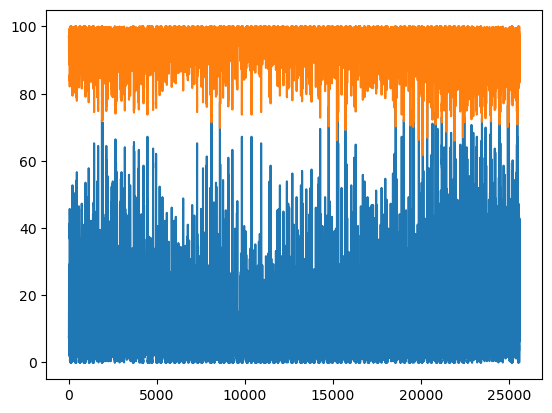

In [19]:
fig, ax = p.subplots()
ax.plot(bad_hist)

precision = 100*(1-bad_hist/(np.shape(distance_error)[0] * np.shape(distance_error)[1]))
recall =  100*(1-bad_hist/(np.shape(distance_error)[0] * np.shape(distance_error)[1]))

F_score = 2*(precision*recall)/(precision+recall)
print(np.mean(F_score))

ax.plot(F_score)

# fig, ax = p.subplots(1,3)
# ax[0].imshow(depth)
# ax[1].imshow(images[j,:,:,0])
# ax[2].imshow(bad)

## Generate  and save NeRF output at all test frames so we can calculate CD in the other notebook

In [ ]:
# np.save("generatedPointClouds/MaiCityNeRFOutput_frame_12.npy" ,reconstructed_pc)
# np.save("generatedPointClouds/MaiCityReal_frame_12.npy", pc1)

In [46]:
num_view = 512 #128 #number of rotational patches to draw
n_bins_coarse = 64 #64 #32
n_bins_fine = 512 #2048 #512 #256

near=0.
far= 1.
n_rots = 512 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

# look_at_scan  = 11 #look at this scan

for look_at_scan in range(50): #25
    print("scan", look_at_scan)
    savepc = np.zeros([0,3]) #to save point cloud to external file

    for j in range(look_at_scan*n_rots, look_at_scan*n_rots + num_view):

        #use |training poses and view directions
        rays_d = rays_d_all[j] #get view directions
        rays_o = rays_o_all[j] #use moving base of platfrom (like in training data)
    #     rays_o = rays_o_all[look_at_scan*n_rots] #simulate static base

#         #use Ouster OS1-64 sensor model to specify new points and view directions
#         # phimin = np.deg2rad(-15.593) #actual OS1
#         # phimax = np.deg2rad(17.743)
#         phimin = np.deg2rad(0) #debug
#         phimax = np.deg2rad(25)
#         rotm = np.eye(4)
#         rotm[0,-1] = look_at_scan/400 #translate forward
#     #     rotm[1,-1] += 3/200 #move down side street
#     #     rotm[2,-1] += 1/200 #raise sensor
#         #rotate sensor about its vertical axis
#         rotm[:3,:3] = rotm[:3,:3] @ R.from_euler('xyz', [0,0,2*np.pi*j/n_rots]).as_matrix()
#         rotm = tf.cast(rotm, tf.float32)
#         rays_o, rays_d = get_rays(H, W, rotm, phimin, phimax)

        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                     #repeat_coarse=False)    
        eps = 1e-3 #1e-3
        weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]

        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]

        #RUN FINE NETWORK
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)    

        #scale back up to normal size
        depth /= scale_factor
        ray_drop = tf.transpose(ray_drop).numpy()
        ray_drop = np.flip(ray_drop, axis = 0)
        #just use rays_d to get point directions! 
        new_point_cloud_cart = depth[:,:,None]*rays_d #+ rays_o
        new_point_cloud_cart = np.reshape(new_point_cloud_cart, [-1,3])

        savepc = np.append(savepc, new_point_cloud_cart, axis = 0)
       
    
    pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{(2*look_at_scan+1):06}" #+ ".txt"
    # pcfn = "/media/derm/06EF-127D4/mai_city/txt/00/" +  f"{look_at_scan:06}" #+ ".txt"
    pc1 = np.loadtxt(pcfn)
    pc1 = pc1[:131_072,:]
    
    np.save("generatedPointClouds/MaiCityNeRFOutput_v2_frame_" + str(look_at_scan) + ".npy" ,savepc)
    np.save("generatedPointClouds/MaiCityReal_v2_frame_" + str(look_at_scan) + ".npy", pc1)

#     np.save("generatedPointClouds/MaiCityNeRFOutput_velodyne_format_frame_" + str(look_at_scan) + ".npy" ,savepc)

scan 0
scan 1
scan 2
scan 3
scan 4
scan 5
scan 6
scan 7
scan 8
scan 9
scan 10
scan 11
scan 12
scan 13
scan 14
scan 15
scan 16
scan 17
scan 18
scan 19
scan 20
scan 21
scan 22
scan 23
scan 24
scan 25
scan 26
scan 27
scan 28
scan 29
scan 30
scan 31
scan 32
scan 33
scan 34
scan 35
scan 36
scan 37
scan 38
scan 39
scan 40
scan 41
scan 42
scan 43
scan 44
scan 45
scan 46
scan 47
scan 48
scan 49


In [ ]:
#debug getting rays_d from pc1_patch
# print(pc1_patch)
# norm = np.sqrt(np.sum(pc1_patch**2, axis = 1))
# print(norm)
# print(pc1_patch/norm[:,None])
# print("rays_d_all", np.shape(rays_d_all))

# #TODO----- debug getting rays_o
# idx = 5
# rays_o = np.array([idx, 0., 0.])
# print("rays_o: \n", rays_o)
# rays_o = np.tile(rays_o, [1,64, 2048//n_rots,1])
# print(np.shape(rays_o))
# # print(rays_o)

# print(np.shape(pc1_distorted))
pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{idx:06}" #+ ".txt"
pc1 = np.loadtxt(pcfn)
m_hat = np.array([-1.,0.,0.,0.,0.,0.])
pc1_distorted = apply_motion_profile(pc1, m_hat, period_lidar=1.)
pc1_distorted += np.array([idx,0,0])
pc1_distorted = pc1_distorted[:131_072,:] #crop down to 2048 "pixels" in sweep
print(np.shape(pc1_distorted))

r = 0#dummy
pc1_patch = pc1_distorted[r*W*H:(r+1)*W*H,:]
print(np.shape(pc1_patch))
pc1_spherical = cartesian_to_spherical(pc1_patch)

pc1_spherical = pc1_spherical[:,0]
pc1_depth_image = np.reshape(pc1_spherical, [-1,64]).T
print(np.shape(pc1_depth_image))

fig, ax = p.subplots()
ax.imshow(pc1_depth_image)

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
# disp=[]
# disp.append(Points(pc1_patch, r = 3, c = np.random.rand(3), alpha = 0.2))
# plt.show(disp, "using data from rosbag not ply files")
# ViewInteractiveWidget(plt.window)

In [ ]:
# print(np.shape(pc1_spherical))
pc1_spherical = cartesian_to_spherical(pc1_distorted)

#sort by azimuth angle

pc1_spherical = pc1_spherical[:,0]
pc1_depth_image = np.reshape(pc1_spherical, [len(pc1_distorted)//64,-1]).T
# pc1_depth_image = np.flip(pc1_depth_image, axis = 0)
print(np.shape(pc1_depth_image))

fig, ax = p.subplots()
ax.imshow(pc1_depth_image[:,800:1200])

In [ ]:
def interpolate_missing_angles(pc1):
    """pc1 = cartesian coordinates of point cloud AFTER distortion correction has been applied"""

    pc1_spherical = cartesian_to_spherical(pc1).numpy()
    #test moving wrap around to center -- reduce NaNs??
    pc1_spherical[:,1] += np.pi
    pc1_spherical = tf.cast(pc1_spherical, tf.float32)
    
    ray_drops = tf.where(pc1_spherical[:,0]<0.001)
    non_ray_drops = tf.where(pc1_spherical[:,0]>0.001)

    # Generate a regular 2D grid (source grid)
#     source_grid_x, source_grid_y = np.meshgrid(np.linspace(0, 63, 64), np.linspace(0, 1023, 1024))
    source_grid_x, source_grid_y = np.meshgrid(np.linspace(0, 63, 64), np.linspace(0, len(pc1)//64-1, len(pc1)//64))
    source_points = np.column_stack((source_grid_x.flatten(), source_grid_y.flatten()))
    warped_points = pc1_spherical[:,1:].numpy()
#     print("warped_points", np.shape(warped_points))

    # Select known warped points (subset for interpolation)
    known_indices = non_ray_drops[:,0]
    known_source_points = source_points[known_indices]
    known_warped_points = warped_points[known_indices]

    # Interpolate missing points on the warped grid
    missing_indices = np.setdiff1d(np.arange(len(source_points)), known_indices)  # Remaining points
    missing_source_points = source_points[missing_indices]

    # Use griddata to estimate locations of missing points on the warped grid
    interpolated_points = griddata(known_source_points, known_warped_points, missing_source_points, method='cubic')
#     interpolated_points = np.nan_to_num(interpolated_points, 0)
#     print("\n interpolated_points", np.shape(interpolated_points), interpolated_points)

    #fill interpolated points back in to missing locations
    full_points_spherical = tf.zeros_like(pc1_spherical).numpy()[:,:2]
    #combine via mask old and new interpolated points
    full_points_spherical[non_ray_drops[:,0]] = known_warped_points
    full_points_spherical[ray_drops[:,0]] = interpolated_points

    full_points_spherical = np.append(np.ones([len(full_points_spherical), 1]), full_points_spherical, axis = 1)
    full_points = spherical_to_cartesian(full_points_spherical)
#     print("\n full_points_spherical", np.shape(full_points_spherical), tf.math.reduce_sum(full_points_spherical))

    print(np.shape(interpolated_points))

    p.figure(figsize=(10, 6))
    p.scatter(*zip(*known_warped_points[::10]), color='blue', label='Known Warped Points')
    p.scatter(interpolated_points[:,0], interpolated_points[:,1], color='red', label='Interpolated Points')
    p.legend()
    p.title("Warped Grid with Known and Interpolated Points")
    p.show()

    print(interpolated_points)

    return full_points

idx1 = 30
pcfn = "/media/derm/06EF-127D4/mai_city/txt/01/" +  f"{idx1:06}" #+ ".txt"
pc1 = np.loadtxt(pcfn)
m_hat = np.array([-1.,0,0,0,0,0.])
pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
pc1 = pc1[:131_072,:] #crop conservatively so we don't overlap 
full_points = interpolate_missing_angles(pc1)